In [ ]:
#  ------------------------------------------------------------------------------------
#  ------------------------------------------------------------------------------------
#
#      ,o888888o.        ,o888888o.       d888888o.   8 888888888o  `8.`8888.      ,8' 
#     8888     `88.   . 8888     `88.   .`8888:' `88. 8 8888    `88. `8.`8888.    ,8'  
#  ,8 8888       `8. ,8 8888       `8b  8.`8888.   Y8 8 8888     `88  `8.`8888.  ,8'   
#  88 8888           88 8888        `8b `8.`8888.     8 8888     ,88   `8.`8888.,8'    
#  88 8888           88 8888         88  `8.`8888.    8 8888.   ,88'    `8.`88888'     
#  88 8888           88 8888         88   `8.`8888.   8 888888888P'      `8. 8888      
#  88 8888           88 8888        ,8P    `8.`8888.  8 8888              `8 8888      
#  `8 8888       .8' `8 8888       ,8P 8b   `8.`8888. 8 8888               8 8888      
#     8888     ,88'   ` 8888     ,88'  `8b.  ;8.`8888 8 8888               8 8888      
#      `8888888P'        `8888888P'     `Y8888P ,88P' 8 8888               8 8888      
#
#  ------------------------------------------------------------------------------------
#  ------------------------------------------------------------------------------------

In [ ]:
# --------------------
# import packages 
# --------------------

import h5py
import math
import numpy as np
import matplotlib as mpl

#import matplotlib.cbook as cbook

from numpy import cos, sin, sqrt, exp
from scipy.optimize import curve_fit, leastsq

from cospy.interface import * 
%matplotlib inline  

from matplotlib import cm

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

from sympy.interactive import printing
printing.init_printing(use_latex=True)

from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed
from IPython.html import widgets


In [ ]:
# --------------------

time_step = '1'

# --------------------
# exact solution
# --------------------

zi = 1
w  = 0.0005

def solution(x, y, z, t):

    h      = 0.38
    hh     = 0.125657*1.75
    sigma2 = 1**2
    r1     = sqrt(x**2 + y**2 + z**2) 
    r2     = x**2 + y**2 + z**2

    return h*exp(-hh*r2)*cos(w*t)

# --------------------
# data
# --------------------

file_list = list()

file_list.append('/Users/fuentes/workspace/sp_x0_32_t1/output.h5')
file_list.append('/Users/fuentes/workspace/sp_x0_64_t1/output.h5')
file_list.append('/Users/fuentes/workspace/sp_x0_128_t1/output.h5')

# --------------------
# computing abs-error
# --------------------

E = list()

for fl in file_list:
    
    h5file = h5py.File(fl)
    
    u = h5file['psiR/' + time_step]
    t = u.attrs['time']
    
    xx = np.array(h5file['coordinates/x'])
    yy = np.array(h5file['coordinates/y'])
    zz = np.array(h5file['coordinates/z'])
    
    Udiff = np.abs(u - solution(xx,yy,zz,1))
    E.append(np.linalg.norm(Udiff.flatten()))
    h5file.close()
    
# --------------------
# least squares
# --------------------

y = E
x = np.array([1/float(2**n) for n in range(7,4,-1)])

funcLine = lambda tpl, x: tpl[0]*x    + tpl[1]
funcQuad = lambda tpl, x: tpl[0]*x**2 + tpl[1]*x + tpl[2]

func = funcLine
ErrorFunc = lambda tpl, x, y: func(tpl, x) - y
tplInitial1 = (1.0, 2.0) # arbitrary

tplFinal1,success = leastsq(ErrorFunc, tplInitial1[:], args = (x, y))

# --------------------
# linear fit
# --------------------

x1 = np.linspace(x.min(), x.max(), 50)
y1 = func(tplFinal1, x1)

# --------------------
# quadratic fit
# --------------------

func = funcQuad
tplInitial2 = (1.0, 2.0, 3.0) # arbitrary

tplFinal2, success = leastsq(ErrorFunc, tplInitial2[:], args = (x, y))

x2 = x1
y2 = func(tplFinal2, x2)

# --------------------
# maps
# --------------------

fig = plt.figure()
map = fig.add_subplot(111)

map.set_title('Convergence test')
map.set_xlabel('$1/N$')
map.set_ylabel('$|E|$')
map.grid(True)

map.loglog(x,   y, 'o' )
map.loglog(x2, y2, '--')

plt.xlim([1/512,1])
plt.ylim([-100,1000])

plt.show()


In [ ]:
# --------------------
# maps wavefunction
# --------------------

file_sp ='/Users/fuentes/workspace/sp_x4_64g_t12/output.h5'
data_sp = h5py.File(file_sp)

# --------------------

nx = data_sp['coordinates/x'][:,0,0].shape[0]
x_slider = widgets.IntSlider(min=0,max=nx-1,value=25,description='X index')

ny = data_sp['coordinates/y'][0,:,0].shape[0]
y_slider = widgets.IntSlider(min=0,max=ny-1,value=55,description='Y index')

nz = data_sp['coordinates/z'][0,0,:].shape[0]
z_slider = widgets.IntSlider(min=0,max=nz-1,value=nz/8,description='Z index')

# --------------------

def plot_timestep(xi, yi, zi):


    fig = plt.figure()
    fig.clf()
    ax = Axes3D(fig)

    # iter_time = str(t)

    X = data_sp['coordinates/x'][:,30:100,zi]
    Y = data_sp['coordinates/y'][:,30:100,zi]
    U = data_sp['psiR/1'][:,30:100,zi]
    
    ax.plot_wireframe(X, Y, U, color = 'Black',linewidth=.125)
    ax.w_xaxis.set_pane_color((1.0,1.0,1.0))
    ax.w_yaxis.set_pane_color((1.0,1.0,1.0))
    ax.view_init(elev=xi,azim=yi)  
    ax.grid(b=False)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('Re $\Psi$')
    
    #ax.set_zlim3d([-.75,.75])
    
    fig.savefig('ho_0.png', dpi=200)

interact(plot_timestep, xi = x_slider, yi = y_slider, zi = z_slider)


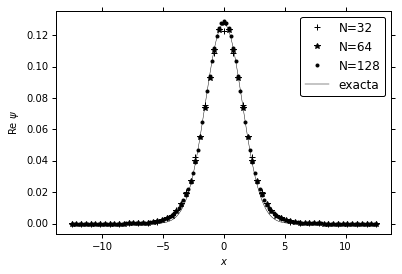

In [159]:
# --------------------
# maps wf profile
# --------------------

file_sp32 ='/Users/fuentes/workspace/sp_x0_32_t1/output.h5'
data_sp32 = h5py.File(file_sp32)

file_sp64 ='/Users/fuentes/workspace/sp_x0_64_t1/output.h5'
data_sp64 = h5py.File(file_sp64)

file_sp128 ='/Users/fuentes/workspace/sp_x0_128_t1/output.h5'
data_sp128 = h5py.File(file_sp128)

# --------------------

zi = 0
w  = 0.0005

def solution(x, y, z, t):

    h      = 0.12758447
    hh     = 0.22
    sigma2 = 1**2
    r1     = sqrt(x**2 + y**2 + z**2) 
    r2     = x**2 + y**2 + z**2

    return h*exp(-hh*r2)*cos(w*t)


X32 = data_sp32['coordinates/x'][:,zi,zi]
U32 = data_sp32['psiR/1'][:,zi,zi]

X64 = data_sp64['coordinates/x'][:,zi,zi]
U64 = data_sp64['psiR/1'][:,zi+1,zi+1]

X128 = data_sp128['coordinates/x'][:,zi,zi]
U128 = data_sp128['psiR/1'][:,zi+3,zi+3]

fig = plt.figure()
fig.clf()

map = fig.add_subplot(111)

map.plot(X32,U32,'k+',linewidth=.15,label='N=32')
map.plot(X64,U64,'k*',linewidth=.15,label='N=64')
map.plot(X128,U128,'k.',linewidth=.15,label='N=128')
map.plot(X128,solution(X128,0,0,zi),'k-',linewidth=.45,label='exacta')

map.set_xlabel('$x$')
map.set_ylabel('Re $\psi$')

legend = map.legend(loc='upper right', shadow=False)

plt.show()
fig.savefig('sp_x4_pf_conv.png', dpi=300)


In [ ]:
# --------------------
# maps potential
# --------------------

file_sp ='/Users/fuentes/workspace/sp_x1_64_t1/output.h5'
data_sp = h5py.File(file_sp)

# --------------------

nx = data_sp['coordinates/x'][:,0,0].shape[0]
x_slider = widgets.IntSlider(min=0,max=nx-1,value=nx/2,description='X index')

ny = data_sp['coordinates/y'][0,:,0].shape[0]
y_slider = widgets.IntSlider(min=0,max=ny-1,value=ny/2,description='Y index')

nz = data_sp['coordinates/z'][0,0,:].shape[0]
z_slider = widgets.IntSlider(min=0,max=nz-1,value=nz/8,description='Z index')

#frames = len(data_sp['U/1'.keys())-1
#time_slider = widgets.IntSlider(min=1,max=frames,value=1,description='Time')

# --------------------

def plot_timestep(xi, yi, zi):

    fig = plt.figure()
    fig.clf()
    ax = Axes3D(fig)

   # iter_time = str(t)

    X = data_sp['coordinates/x'][:,:,zi]
    Y = data_sp['coordinates/y'][:,:,zi]
    U = data_sp['UI/1'][:,:,zi]

    ax.plot_wireframe(X, Y, U, color = 'Black')
    fig.savefig('ipotential.png', dpi=200)

    
interact(plot_timestep, xi = x_slider, yi = y_slider, zi = z_slider)

In [ ]:
# --------------------
# clear workspace
# --------------------

%reset